# Функции потерь

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


## 1) Регрессия

#### Кастомные функции

In [2]:
import torch
preds = torch.tensor([2.5, 3.0, 1.8])
targets = torch.tensor([2.0, 3.2, 1.5])


def mse_custom(preds, targets):
    return torch.mean((preds - targets) ** 2)

def rmse_custom(preds, targets):
    return torch.sqrt(mse_custom(preds, targets))

def mae_custom(preds, targets):
    return torch.mean(torch.abs(preds - targets))

loss_mse = mse_custom(preds, targets)
print(f"MSE Loss: {loss_mse.item():.4f}")

loss_rmse= rmse_custom(preds, targets)
print(f"rmse Loss: {loss_rmse.item():.4f}")

loss_mae = mae_custom(preds, targets)
print(f"mae Loss: {loss_mae.item():.4f}")


MSE Loss: 0.1267
rmse Loss: 0.3559
mae Loss: 0.3333


### 1. Mean Squared Error Loss (MSELoss)

Вычисляет средний квадрат разницы между предсказанными и истинными значениями.  

Очень чувствительна к большим ошибкам (выбросам).  

In [3]:
import torch
import torch.nn as nn


criterion = nn.MSELoss()

predictions = torch.tensor([2.5, 3.0, 1.8])
targets = torch.tensor([2.0, 3.2, 1.5])

loss = criterion(predictions, targets)
print(f"MSE Loss: {loss.item():.4f}")



MSE Loss: 0.1267


### 2. Mean Absolute Error Loss (L1Loss) 

Среднее абсолютное отклонение.  

Более робастна к выбросам, чем MSE.  

In [4]:
criterion_mae = nn.L1Loss()

predictions = torch.tensor([2.5, 3.0, 1.8])
targets = torch.tensor([2.0, 3.2, 1.5])

loss_mae = criterion_mae(predictions, targets)
print(f"MAE Loss: {loss_mae.item():.4f}")


MAE Loss: 0.3333


### 3. Huber Loss (Smooth L1 Loss) 

Комбинация MSE и MAE, помогает уменьшить влияние выбросов.

In [5]:
criterion_huber = nn.SmoothL1Loss()

predictions = torch.tensor([2.5, 3.0, 1.8])
targets = torch.tensor([2.0, 3.2, 1.5])

loss_huber = criterion_huber(predictions, targets)
print(f"Huber Loss: {loss_huber.item():.4f}")


Huber Loss: 0.0633


## 2) Классификация

In [6]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
import torch.nn as nn



In [7]:
# Шаг 1: Создание данных
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1,
                           weights=[0.5, 0.5], random_state=42)

# Шаг 2: Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Шаг 3: Обучение модели sklearn
model = LogisticRegression()
model.fit(X_train, y_train)

# Шаг 4: Получение вероятностей для класса 1
y_probs = model.predict_proba(X_test)[:, 1]  # вероятности принадлежности к классу 1

# Переводим в тензоры
y_probs_torch = torch.tensor(y_probs, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)



### Бинарная кросс-энтропия 

nn.BCELoss — для вероятностей

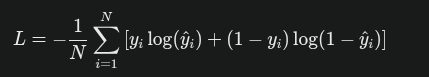

In [8]:
# Шаг 5: Создаем функцию потерь BCELoss для вероятностей
criterion = nn.BCELoss()

# Вычисляем loss
loss = criterion(y_probs_torch, y_test_torch)
print("Loss:", loss.item())

Loss: 0.39712637662887573


nn.BCEWithLogitsLoss — для логитов

In [9]:
import torch

# Параметры
batch_size = 8
height = 64
width = 64

# Случайные логиты модели (до сигмоида, могут быть положительные и отрицательные)
logits_binary = torch.randn(batch_size, 1, height, width, requires_grad=True)

# Бинарные метки (0 или 1)
# Формируем случайные метки для каждого пикселя, размер совпадает с логитами по spatial размеру
targets_binary = torch.randint(0, 2, (batch_size, 1, height, width)).float()

print("Logits shape:", logits_binary.shape)  # (8,1,64,64)
print("Targets shape:", targets.shape)  # (8,1,64,64)

# Теперь такие данные можно подать в nn.BCEWithLogitsLoss
criterion = torch.nn.BCEWithLogitsLoss()
loss = criterion(logits_binary, targets_binary)
print("Loss:", loss.item())

Logits shape: torch.Size([8, 1, 64, 64])
Targets shape: torch.Size([3])
Loss: 0.8048728108406067


In [10]:
# Для логитов
def bce_loss_torch(y_real, y_pred):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    y_pred = y_pred.type(torch.float32)
    y_real = y_real.type(torch.float32)

    loss = F.relu(y_pred) - y_real * y_pred + torch.log(1. + torch.exp(-abs(y_pred)))
    return torch.mean(loss)


loss_bce = bce_loss_torch(targets_binary, logits_binary)
print("Loss_bce:", loss_bce.item())

Loss_bce: 0.8048727512359619


### Категориальная Кросс-энтропия 

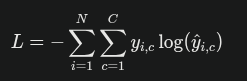  

In [26]:
import torch
import torch.nn as nn

# Пример: 3 класса, батч из 4 объектов.
# Пусть выход модели — логиты (не softmax)
logits = torch.tensor([         # (batch_size, num_classes)
    [1.2, 0.5, 2.1],   # пример 1
    [0.1, 2.0, 1.5],   # пример 2
    [1.5, 0.2, 0.3],   # пример 3
    [0.0, 1.0, 1.0]    # пример 4
], requires_grad=True)


# Правильные метки классов (индексы от 0 до 2)
targets = torch.tensor([2, 1, 0, 1])  # размер [batch_size], каждый элемент - класс

# Создаем функцию потерь CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Считаем loss
loss = criterion(logits, targets)

print("Loss:", loss.item())


Loss: 0.5884541869163513


In [32]:
import torch

# Предсказанные вероятности после softmax (пример)
probs = torch.tensor([
    [0.1, 0.3, 0.6],
    [0.1, 0.7, 0.2],
    [0.8, 0.1, 0.1],
    [0.2, 0.7, 0.1]
])

targets = torch.tensor([2, 1, 0, 1])

# Для cross-entropy вручную нужен log вероятностей и индексы классов
log_probs = torch.log(probs)
print("log_probs: ", log_probs)
# Выбираем логарифмы для правильных классов:
loss_per_sample = -log_probs[range(len(targets)), targets]
print("loss_per_sample: ", loss_per_sample)
# Среднее значение по батчу
loss_manual = loss_per_sample.mean()

print("Manual cross-entropy loss:", loss_manual.item())


log_probs:  tensor([[-2.3026, -1.2040, -0.5108],
        [-2.3026, -0.3567, -1.6094],
        [-0.2231, -2.3026, -2.3026],
        [-1.6094, -0.3567, -2.3026]])
loss_per_sample:  tensor([0.5108, 0.3567, 0.2231, 0.3567])
Manual cross-entropy loss: 0.3618297576904297


## 3) Компьютерное зрение 

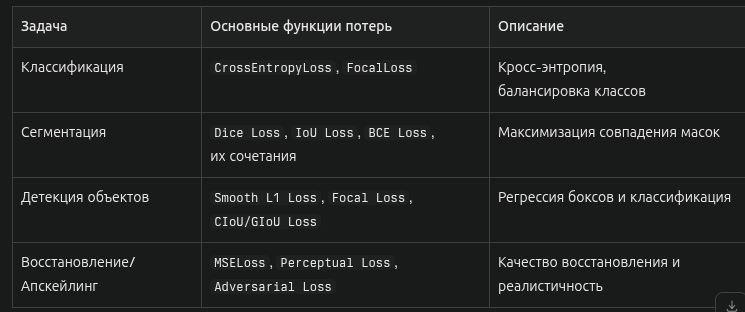

### 1. Классификация

In [31]:
# bce_loss_torch  или  torch.nn.BCEWithLogitsLoss

def bce_loss_torch(y_real, y_pred):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    y_pred = y_pred.type(torch.float32)
    y_real = y_real.type(torch.float32)

    loss = F.relu(y_pred) - y_real * y_pred + torch.log(1. + torch.exp(-abs(y_pred)))
    return torch.mean(loss)

loss = bce_loss_torch(targets_binary, logits_binary)  # targets - индексы классов
print(loss.item())

0.8023167848587036


In [32]:
criterion = nn.CrossEntropyLoss()
# logits = model(inputs)  # (batch_size, num_classes)
loss = criterion(logits, targets)  # targets - индексы классов
print(loss.item())

0.5884541869163513


In [33]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


loss = FocalLoss()
loss(logits, targets).item()

0.1300818920135498

### 2. Сегментация

#### Кросэнтропия

In [ ]:
# БИНАРНАЯ сегментация  с вероятностями
criterion = nn.BCELoss()

# Вычисляем loss
loss = criterion(y_probs_torch, y_test_torch)
print("Loss:", loss.item())

Loss: 0.39712637662887573


In [ ]:
# Многоклассовая сегментация  с логитами
criterion = torch.nn.BCEWithLogitsLoss()
loss = criterion(logits_binary, targets_binary)

print(loss.item())

0.8023167848587036


#### dice_loss

In [ ]:
# бинарная сегментация
def dice_loss(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice


In [ ]:
import torch
import torch.nn.functional as F
# многоклассовая
def dice_loss(y_real, y_pred, num_classes=19, smooth=1e-8):
    """
    Многоклассовая Dice Loss с поддержкой пропуска отсутствующих классов.
    
    Args:
        y_real: [B, H, W] Ground truth маска (целые числа 0..num_classes-1)
        y_pred: [B, C, H, W] Логиты модели
        num_classes: Количество классов
        smooth: Сглаживающий коэффициент
        
    Returns:
        Среднее значение Dice Loss по присутствующим классам
    """
    # Применяем softmax к предсказаниям
    y_pred_softmax = torch.softmax(y_pred, dim=1)
    
    # Конвертируем маски в one-hot представление
    y_real_onehot = F.one_hot(y_real, num_classes=num_classes).permute(0, 3, 1, 2).float()
    
    # Вычисляем intersection и union для всех классов
    intersection = torch.sum(y_pred_softmax * y_real_onehot, dim=(0, 2, 3))
    union = torch.sum(y_pred_softmax, dim=(0, 2, 3)) + torch.sum(y_real_onehot, dim=(0, 2, 3))
    
    # Определяем присутствующие классы
    class_present = torch.sum(y_real_onehot, dim=(0, 2, 3)) > 0
    
    # Вычисляем Dice для каждого класса
    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    
    # Усредняем только по присутствующим классам
    if torch.any(class_present):
        dice_avg = torch.mean(dice_per_class[class_present])
        return 1 - dice_avg
    return torch.tensor(1.0, device=y_pred.device, requires_grad=True)


####  IoU loss

In [ ]:
# Бинарная
import torch
import torch.nn.functional as F

def iou_loss_binary(pred, target, smooth=1e-6):
    """
    IoU loss для бинарной сегментации.
    pred: вероятности модели после sigmoid, shape [B, 1, H, W]
    target: бинарные метки (0 или 1), shape такой же
    smooth: сглаживающий параметр для стабильности
    
    Возвращает число — потерю (чем меньше, тем лучше).
    """
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou


In [ ]:
# многоклассовая
import torch
import torch.nn.functional as F

def iou_loss_multiclass(y_pred, y_true, num_classes, smooth=1e-6):
    """
    Многоклассовая IoU Loss.
    y_pred: логиты модели, shape [B, C, H, W]
    y_true: цели, shape [B, H, W] с индексами классов
    num_classes: число классов
    smooth: сглаживание
    
    Возвращает усредненную IoU Loss по классам, присутствующим в батче.
    """
    y_pred_soft = F.softmax(y_pred, dim=1)  # вероятности по классам
    
    y_true_onehot = F.one_hot(y_true, num_classes)  # [B, H, W, C]
    y_true_onehot = y_true_onehot.permute(0, 3, 1, 2).float()  # [B, C, H, W]
    
    intersection = (y_pred_soft * y_true_onehot).sum(dim=(0, 2, 3))
    union = (y_pred_soft + y_true_onehot).sum(dim=(0, 2, 3)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    # Выбираем классы, которые есть в y_true
    class_present = (y_true_onehot.sum(dim=(0,2,3)) > 0)
    
    if class_present.sum() == 0:
        # Если классов нет, вернуть максимальную потерю
        return torch.tensor(1.0, device=y_pred.device, requires_grad=True)
    
    iou_loss = 1 - iou[class_present].mean()
    return iou_loss



#### FocalLoss   
учитывает дисбаланс классов 

In [ ]:
# Бинарная сегментация
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')  # без усреднения
    
    def forward(self, inputs, targets):
        """
        inputs: логиты модели размером [B, 1, ...] или [B, ...]
        targets: бинарные метки того же размера (0 или 1)
        """
        bce_loss = self.bce(inputs, targets.float())
        # Применяем sigmoid, чтобы получить вероятности предсказания класса 1
        probas = torch.sigmoid(inputs)
        p_t = probas * targets + (1 - probas) * (1 - targets)  # вероятности правильного класса
        
        focal_factor = (1 - p_t) ** self.gamma
        
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * focal_factor * bce_loss
        else:
            loss = focal_factor * bce_loss
            
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss



In [ ]:
import torch
import torch.nn.functional as F

def focal_loss(y_real, y_pred, gamma=2.0, alpha=0.8, reduction='mean'):
    """
    y_real: тензор бинарных меток (0/1), float32, shape любую, например [B, 1, H, W]
    y_pred: логиты модели (сырые предсказания без sigmoid), того же размера
    gamma: параметр фокусировки
    alpha: баланс классов
    reduction: 'mean', 'sum' или 'none'
    """
    y_real = y_real.type(torch.float32)
    
    bce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
    pt = torch.exp(-bce_loss)  # вероятность правильного класса
    
    focal_loss = alpha * (1 - pt) ** gamma * bce_loss
    
    if reduction == 'mean':
        return focal_loss.mean()
    elif reduction == 'sum':
        return focal_loss.sum()
    else:
        return focal_loss


In [ ]:
# Многоклассовая
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean', ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=self.ignore_index)
    def forward(self, inputs, targets):
        """
        inputs: логиты модели, shape [B, C, ...]
        targets: целочисленные метки классов, shape [B, ...]
        """
        logpt = -self.ce_loss(inputs, targets)  
        pt = torch.exp(logpt)  # вероятности правильных классов

        # Фокусируемся на сложных примерах
        focal_term = (1 - pt) ** self.gamma

        # Балансировка классов
        if self.alpha is not None:
            alpha_t = self.alpha
            loss = -alpha_t * focal_term * logpt
        else:
            loss = -focal_term * logpt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss



#### lovasz_hinge 


In [ ]:
# Бинарная сегментация

# оригинальная функция
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge_flat(logits, labels):
    if len(labels) == 0:
        # no pixels to train on
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss


In [ ]:
# Не оригинальная (не оптимальная)

# https://arxiv.org/pdf/1705.08790.pdf
def grad_lovasz(sorted_errors):

    err_cumm = sorted_errors.float().cumsum(0)
    opp_err_cumm = (1 - sorted_errors).float().cumsum(0)
    p = len(sorted_errors)
    err = sorted_errors.sum()
    intersection = err - err_cumm
    union = err + opp_err_cumm
    grad = 1 - intersection / union
    if p > 1:
        grad[1:p] = grad[1:p] - grad[0:p-1]
    return grad


# https://arxiv.org/pdf/1512.07797.pdf. 
def lovasz_hinge(y_real, y_pred):

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    sgn = 2 * y_real.float() - 1
    errs = (1 - y_pred * torch.tensor(sgn, requires_grad=True))
    sorted_errors, indices = torch.sort(errs, dim=0, descending=True)
    indices = indices.data
    errs_for_grad = y_real[indices]
    grad = grad_lovasz(errs_for_grad)
    loss = torch.dot(F.relu(sorted_errors), torch.tensor(grad, requires_grad=True))
    return loss

In [ ]:
# многоклассовая 

import torch
import torch.nn.functional as F

def lovasz_grad(gt_sorted):
    """
    Вычисляет градиенты Lovász расширения.
    gt_sorted: отсортированные метки (0/1), 1D tensor
    """
    p = gt_sorted.numel()
    gts = gt_sorted.sum().item()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def lovasz_hinge_binary(logits, labels):
    """
    Lovász hinge loss для бинарной сегментации.
    
    logits: 1D tensor (N) — логиты модели для написанных пикселей
    labels: 1D tensor (N) — бинарные метки {0,1}
    
    Returns скалярный loss.
    """
    if labels.numel() == 0:
        return logits.sum() * 0.  # чтобы не ломать вычисления при пустом входе

    labels = labels.float()
    signs = 2. * labels - 1.
    errors = 1. - logits * signs
    errors_sorted, perm = torch.sort(errors, descending=True)
    perm = perm.detach()
    labels_sorted = labels[perm]
    grad = lovasz_grad(labels_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss


def lovasz_hinge(logits, labels, ignore_index=None, classes='present'):
    """
    Многоклассовая Lovász hinge loss через поэлементное вычисление Binary Lovász hinge loss по классам.

    logits: tensor [B, C, H, W] — логйты модели (сырые выходы)
    labels: tensor [B, H, W] — метки классов (LongTensor с индексами классов)
    ignore_index: int или None — значение метки для игнорирования
    classes: 'all' или 'present' — считать loss для всех классов или только для присутствующих в батче.

    Returns среднее значение loss (scalar).
    """

    B, C, H, W = logits.shape
    total_loss = 0.
    count = 0

    for c in range(C):
        # бинарная маска по текущему классу
        fg = (labels == c).float()

        if ignore_index is not None:
            mask = (labels != ignore_index).float()
            fg = fg * mask

        if classes == 'present' and fg.sum() == 0:
            continue  # пропускаем класс, если он не представлен в батче

        for b in range(B):
            logits_flat = logits[b, c].view(-1)
            fg_flat = fg[b].view(-1)

            if ignore_index is not None:
                valid_mask = (labels[b] != ignore_index).view(-1)
                logits_flat = logits_flat[valid_mask]
                fg_flat = fg_flat[valid_mask]

                if logits_flat.numel() == 0:
                    continue  # ничего не считаем для пустых примеров

            loss_b = lovasz_hinge_binary(logits_flat, fg_flat)
            total_loss += loss_b
            count += 1

    if count == 0:
        # если нет классов для подсчета — возвращаем 0
        return torch.tensor(0., device=logits.device)

    return total_loss / count


# 

# logits = выход модели (logits), shape [B, C, H, W]
# labels = целевые метки, shape [B, H, W] с целочисленными классами (int64)

# loss = lovasz_hinge(logits, labels, ignore_index=255, classes='present')
# loss.backward()



### 3. Детекция

#### 1. Smooth L1 Loss (для регрессии координат коробок)

In [45]:
import torch
import torch.nn as nn

criterion_loc = nn.SmoothL1Loss()

# Пример:
# pred_boxes и target_boxes — тензоры формы [N, 4], где 4 — координаты бокса
pred_boxes = torch.randn(10, 4, requires_grad=True)
target_boxes = torch.randn(10, 4)

loss_loc = criterion_loc(pred_boxes, target_boxes)
print("Localization Loss:", loss_loc.item())


Localization Loss: 0.6350587010383606


#### 2. Cross Entropy Loss (для классификации объектов)

In [42]:
criterion_cls = nn.CrossEntropyLoss()

# pred_cls — логиты модели размером [N, num_classes]
# target_cls — целочисленные метки классов размером [N]
pred_cls = torch.randn(10, 3, requires_grad=True)  # например 3 класса
target_cls = torch.randint(0, 3, (10,))

loss_cls = criterion_cls(pred_cls, target_cls)
print("Classification Loss:", loss_cls.item())


Classification Loss: 1.504645586013794


#### 3. Focal Loss для борьбы с несбалансированностью классов (Для классификации объектов)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


focal_loss = FocalLoss()
loss = focal_loss(pred_cls, target_cls)
print("FocalLoss", loss.item())

FocalLoss 0.26159900426864624


In [46]:
loss_final = loss_loc + loss_cls
print("LOSS = ", loss_final.item())


LOSS =  2.1397042274475098


#### 4. Метрики в стиле Yolo

In [ ]:
import torch
import torch.nn.functional as F


####### =========================          box_loss              ==============================

def bbox_iou_ciou(box1, box2, eps=1e-7):
    """
    Вычисление Complete IoU (CIoU) между двумя наборами боксов.
    box1, box2: тензоры Nx4 в формате [x_center, y_center, width, height]
    """
    # Преобразуем в [x1, y1, x2, y2]
    box1_x1 = box1[:, 0] - box1[:, 2] / 2
    box1_y1 = box1[:, 1] - box1[:, 3] / 2
    box1_x2 = box1[:, 0] + box1[:, 2] / 2
    box1_y2 = box1[:, 1] + box1[:, 3] / 2

    box2_x1 = box2[:, 0] - box2[:, 2] / 2
    box2_y1 = box2[:, 1] - box2[:, 3] / 2
    box2_x2 = box2[:, 0] + box2[:, 2] / 2
    box2_y2 = box2[:, 1] + box2[:, 3] / 2

    # Пересечение
    inter_x1 = torch.max(box1_x1, box2_x1)
    inter_y1 = torch.max(box1_y1, box2_y1)
    inter_x2 = torch.min(box1_x2, box2_x2)
    inter_y2 = torch.min(box1_y2, box2_y2)

    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

    # Площади боксов
    area1 = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    area2 = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    union = area1 + area2 - inter_area + eps

    iou = inter_area / union

    # Центры
    center_x1 = box1[:, 0]
    center_y1 = box1[:, 1]
    center_x2 = box2[:, 0]
    center_y2 = box2[:, 1]

    center_dist = (center_x1 - center_x2) ** 2 + (center_y1 - center_y2) ** 2

    # Охватывающий (enclosing) бокс
    enclose_x1 = torch.min(box1_x1, box2_x1)
    enclose_y1 = torch.min(box1_y1, box2_y1)
    enclose_x2 = torch.max(box1_x2, box2_x2)
    enclose_y2 = torch.max(box1_y2, box2_y2)

    enclose_diagonal = (enclose_x2 - enclose_x1) ** 2 + (enclose_y2 - enclose_y1) ** 2 + eps

    # Аспектное соотношение
    w1 = box1[:, 2]
    h1 = box1[:, 3]
    w2 = box2[:, 2]
    h2 = box2[:, 3]

    v = (4 / (3.141592653589793 ** 2)) * (torch.atan(w2 / (h2 + eps)) - torch.atan(w1 / (h1 + eps))) ** 2
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    ciou = iou - (center_dist / enclose_diagonal) - (alpha * v)

    return ciou


def ciou_loss(pred_boxes, target_boxes):
    """
    pred_boxes: [N,4] в формате [x_center, y_center, w, h]
    target_boxes: [N,4] - target boxes такого же формата
    Возвращает scalar loss
    """
    ciou = bbox_iou_ciou(pred_boxes, target_boxes)
    loss = 1 - ciou
    return loss.mean()




####### ==========================    Классификация    cls_loss    ========================

import torch.nn as nn

cls_criterion = nn.CrossEntropyLoss()



####### =========================       DFL   dfl_loss        ===============================

import torch
import torch.nn.functional as F

def distribution_focal_loss(pred, target):
    """
    Simplified DFL.

    pred: [N, n_bins] - logits предсказания распределения для одной из координат бокса (обычно dim 16, 20 и т.п.)
    target: [N] - target float координата (например, x или y в нормализованном виде)

    Возвращает scalar loss.
    """
    # target состоит из float координат - нужно представить в виде распределения «между» соседними integer значениями
    target_left = target.long()
    target_right = target_left + 1

    weight_right = target - target_left.float()
    weight_left = 1 - weight_right

    loss = 0
    loss += weight_left * F.cross_entropy(pred, target_left, reduction='none')
    loss += weight_right * F.cross_entropy(pred, target_right.clamp(max=pred.size(1) - 1), reduction='none')

    return loss.mean()





################     =====================      Итоговый лосс       =============================

class YOLOLossExample(nn.Module):
    def __init__(self, lambda_box=5.0, lambda_noobj=0.5):
        super(YOLOLossExample, self).__init__()
        self.lambda_box = lambda_box
        self.lambda_noobj = lambda_noobj
        self.cls_loss_fn = nn.CrossEntropyLoss()
        # DFL нет встроенного loss в PyTorch, надо писать свой (см. выше)

    def forward(self, pred_boxes, target_boxes, pred_cls, target_cls, pred_obj, target_obj, pred_dfl, target_dfl):
        """
        pred_boxes: [N,4] - предсказанные боксы (логиты координат, для ciou_loss нужны реальные координаты)
        target_boxes: [N,4] - целевые боксы
        pred_cls: [N,num_classes] - логиты классов
        target_cls: [N] - индексы классов целевых
        pred_obj: [N] - логиты confidence (objectness)
        target_obj: [N] - 0/1 индикатор объекта
        pred_dfl: [N,n_bins] - DFL logits для координат
        target_dfl: [N] - флоат-координаты целевые

        Возвращает общий loss.
        """

        # box_loss c помощью ciou_loss
        loss_box = ciou_loss(pred_boxes, target_boxes)

        # классификационный loss
        loss_cls = self.cls_loss_fn(pred_cls, target_cls)

        # objectness loss (BCE)
        loss_obj = F.binary_cross_entropy_with_logits(pred_obj, target_obj.float())

        # DFL loss
        loss_dfl = distribution_focal_loss(pred_dfl, target_dfl)

        return self.lambda_box * loss_box + loss_cls + loss_obj + loss_dfl


### 4. Восстановление и улучшение качества изображений

#### 1. Mean Squared Error (MSE) — Среднеквадратичная ошибка  
Очень распространённая функция для регрессии пикселей, штрафует большие ошибки сильнее.

In [ ]:
import torch.nn as nn

criterion = nn.MSELoss()

# Пример использования:
# output и target — тензоры формы [B, C, H, W]
loss = criterion(output, target)


#### 2. Mean Absolute Error (MAE) / L1 Loss — Средняя абсолютная ошибка  
Более устойчива к выбросам и резким изменениям, чем MSE.

In [ ]:
criterion = nn.L1Loss()

loss = criterion(output, target)


#### 3. Perceptual Loss (Feature Loss) 


In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F

class PerceptualLoss(nn.Module):
    def __init__(self, feature_layer=16):  # Например, берем слой relu3_3 в VGG16
        super().__init__()
        vgg = models.vgg16(pretrained=True).features
        self.features = vgg[:feature_layer].eval()  # Выделяем часть модели
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        # Нормализуем по ImageNet если надо
        output_features = self.features(output)
        target_features = self.features(target)
        loss = F.l1_loss(output_features, target_features)
        return loss

#### 4. Structural Similarity Index (SSIM) Loss 

SSIM — метрика, учитывающая структуру, освещение и контраст, ближе к человеческому восприятию качества.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def gaussian(window_size, sigma):
    x = torch.arange(window_size).float()
    center = window_size // 2
    gauss = torch.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)  # [window_size, 1]
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)  # [1,1,window_size,window_size]
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    """
    Возвращает SSIM индекс между img1 и img2 с размером окна window_size.
    img1, img2 : тензоры размера (B, C, H, W)
    """
    if val_range is None:
        max_val = 1 if torch.max(img1) <= 1 else 255
        min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = window_size // 2
    (B, C, H, W) = img1.size()

    if window is None:
        window = create_window(window_size, C).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=C)
    mu2 = F.conv2d(img2, window, padding=padd, groups=C)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=C) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=C) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=C) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        ssim_val = ssim_map.mean()
    else:
        ssim_val = ssim_map.mean(1).mean(1).mean(1)

    if full:
        # Возвращаем полноценный SSIM и карту contrast sensitivity (необязательно)
        cs_map = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
        if size_average:
            cs = cs_map.mean()
        else:
            cs = cs_map.mean(1).mean(1).mean(1)
        return ssim_val, cs

    return ssim_val


class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average

    def forward(self, img1, img2):
        return 1 - ssim(img1, img2, window_size=self.window_size, size_average=self.size_average)


In [ ]:
criterion = SSIMLoss()

output = torch.rand(4, 3, 128, 128, requires_grad=True)  # output модели, значения в диапазоне [0,1]
target = torch.rand(4, 3, 128, 128)  # эталонное изображение

loss = criterion(output, target)
print("SSIM Loss:", loss.item())

loss.backward()  # можно применять в оптимизации


SSIM Loss: 0.9631375670433044


#### PSNR 

In [ ]:
import torch

def psnr_loss(output, target, max_val=1.0, eps=1e-8):
    """
    Функция потерь на основе PSNR.
    output, target: тензоры с изображениями в диапазоне [0, max_val]
    max_val: максимальное значение пикселя (обычно 1 или 255)
    Возвращает отрицательное значение PSNR (чтобы минимизировать).
    """
    mse = torch.mean((output - target) ** 2)
    psnr = 10 * torch.log10(max_val ** 2 / (mse + eps))
    return -psnr  # отрицательное, чтобы минимизировать в обучении


#### 6. Adversarial Loss (GAN loss) — используется в GAN-подходах к реставрации  
Для GAN, в качестве потерь добавляют adversarial loss для улучшения реалистичности результатов.

In [ ]:
import torch.nn as nn

class ImageRestoreLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.perceptual = PerceptualLoss()

        self.alpha = alpha
        self.beta = beta

    def forward(self, output, target):
        loss_mse = self.mse(output, target)
        loss_perc = self.perceptual(output, target)
        return self.alpha * loss_mse + self.beta * loss_perc
